# HWAI Project TODO:Code cleanup

Import section

In [1]:
import sys, os, pathlib
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers, optimizers
from keras.applications import MobileNetV2
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import visualkeras, logging

#tflite
import tensorflow_model_optimization as tfmot


# my import
from modules import models

#suppress warnings
tf.get_logger().setLevel(logging.ERROR)

2023-04-28 10:45:56.570173: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-28 10:45:57.162719: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [18]:
IMAGESIZE = 128 #TODO: Check arduino cam size
DATADIR = "/home/mattiamorabito/Documents/HwAi-linux/train/"
DATADIRT = "/home/mattiamorabito/Documents/HwAi-linux/test/"

In [3]:
IMAGESIZE = 128 #TODO: Check arduino cam size
DATADIR_train = "/home/mattiamorabito/Documents/HwAi-linux/RottenCAM.v2i.folder/train/"
DATADIR_valid = "/home/mattiamorabito/Documents/HwAi-linux/RottenCAM.v2i.folder/valid/"
DATADIR_test  = "/home/mattiamorabito/Documents/HwAi-linux/RottenCAM.v2i.folder/test/"

Check if GPU is mounted

In [4]:
device_name = tf.test.gpu_device_name()
print(device_name)
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

/device:GPU:0
Found GPU at: /device:GPU:0


2023-04-28 10:46:23.171573: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-28 10:46:23.198808: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-28 10:46:23.199005: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Loading dataset

In [5]:
#TODO: Add plots for dataset
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = tf.keras.utils.image_dataset_from_directory(
                DATADIR_train,seed = 26,
                labels='inferred',
                label_mode='categorical',
                shuffle=True,
                image_size=(IMAGESIZE, IMAGESIZE)).map(lambda x, y: (normalization_layer(x), y)).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds   = tf.keras.utils.image_dataset_from_directory(
                DATADIR_valid,
                seed = 26,
                labels='inferred',
                label_mode='categorical',
                shuffle=True,
                image_size=(IMAGESIZE, IMAGESIZE)).map(lambda x, y: (normalization_layer(x), y)).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Found 19629 files belonging to 8 classes.
Found 1309 files belonging to 8 classes.


2023-04-28 10:46:27.868574: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-28 10:46:27.868778: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-28 10:46:27.868910: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [20]:
#train_ds = [1,2]
#Load training set
#train_ds[0] = tf.keras.utils.image_dataset_from_directory(DATADIR,labels='inferred',label_mode='categorical',shuffle=True,image_size=(IMAGESIZE, IMAGESIZE))
#Load validation set
#train_ds[1] = tf.keras.utils.image_dataset_from_directory(DATADIRV,labels='inferred',label_mode='categorical',shuffle=True,image_size=(IMAGESIZE, IMAGESIZE))

#normalization layer to rescale the images
normalization_layer = tf.keras.layers.Rescaling(1./255)

#small dataset to run tests
train_ds = tf.keras.utils.image_dataset_from_directory(DATADIR,seed = 26,labels='inferred',validation_split=.15,subset='both',label_mode='categorical',shuffle=True,image_size=(IMAGESIZE, IMAGESIZE))
classes = train_ds[1].class_names
#prefetch for performance and rescale
train_ds[0] = train_ds[0].map(lambda x, y: (normalization_layer(x), y)).cache().prefetch(buffer_size=tf.data.AUTOTUNE)    # cache and prefetch of the first element (the training set)
train_ds[1] = train_ds[1].map(lambda x, y: (normalization_layer(x), y)).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Found 8648 files belonging to 8 classes.
Using 7351 files for training.
Using 1297 files for validation.


Model instances and visualization

In [6]:
# Istanciate Model    
model = models.deep_tiny_x5_xl()
#model = models.minimalmodel(num_classes=8)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 58, 32)        25632     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 29, 29, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 32)        25632     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 32)       0

Model Training (With QAT) [See Ex4 28/04/2023]

In [7]:
quantize_model = tfmot.quantization.keras.quantize_model

# q_aware stands for for quantization aware.
q_aware_model = quantize_model(model)

# `quantize_model` requires a recompile.
q_aware_model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizers.Adam(learning_rate=0.00002),
        metrics=['accuracy']
    )

q_aware_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer (QuantizeLay  (None, 128, 128, 3)      3         
 er)                                                             
                                                                 
 quant_conv2d (QuantizeWrapp  (None, 124, 124, 32)     2499      
 erV2)                                                           
                                                                 
 quant_max_pooling2d (Quanti  (None, 62, 62, 32)       1         
 zeWrapperV2)                                                    
                                                                 
 quant_conv2d_1 (QuantizeWra  (None, 58, 58, 32)       25699     
 pperV2)                                                         
                                                                 
 quant_max_pooling2d_1 (Quan  (None, 29, 29, 32)       1

Model training (Without QAT)

In [8]:
#set checkpoint
checkpoint = ModelCheckpoint('savedmodels/QAT.h5', save_best_only=True)
#train with gpu
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        epochs=10,
        batch_size=32,
        callbacks=[
            checkpoint,
            tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.8, min_lr=1e-6)
            ],
        validation_data=val_ds
    )

Epoch 1/10


2023-04-28 10:46:47.997592: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [19629]
	 [[{{node Placeholder/_0}}]]
2023-04-28 10:46:47.997913: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [19629]
	 [[{{node Placeholder/_0}}]]
2023-04-28 10:46:51.444788: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900


614/614 [==============================] - ETA: 0s - loss: 2.0511 - accuracy: 0.1533

2023-04-28 10:47:23.302624: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1309]
	 [[{{node Placeholder/_4}}]]
2023-04-28 10:47:23.303172: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1309]
	 [[{{node Placeholder/_4}}]]


614/614 [==============================] - 37s 44ms/step - loss: 2.0511 - accuracy: 0.1533 - val_loss: 1.9947 - val_accuracy: 0.2124 - lr: 1.0000e-05
Epoch 2/10
614/614 [==============================] - 25s 40ms/step - loss: 1.9582 - accuracy: 0.2444 - val_loss: 1.8907 - val_accuracy: 0.2972 - lr: 1.0000e-05
Epoch 3/10
614/614 [==============================] - 25s 40ms/step - loss: 1.9008 - accuracy: 0.2855 - val_loss: 1.8537 - val_accuracy: 0.3499 - lr: 1.0000e-05
Epoch 4/10
614/614 [==============================] - 25s 40ms/step - loss: 1.8696 - accuracy: 0.3161 - val_loss: 1.8054 - val_accuracy: 0.3843 - lr: 1.0000e-05
Epoch 5/10
614/614 [==============================] - 25s 40ms/step - loss: 1.8367 - accuracy: 0.3448 - val_loss: 1.7767 - val_accuracy: 0.4011 - lr: 1.0000e-05
Epoch 6/10
614/614 [==============================] - 25s 40ms/step - loss: 1.8109 - accuracy: 0.3520 - val_loss: 1.7468 - val_accuracy: 0.4263 - lr: 1.0000e-05
Epoch 7/10
614/614 [=========================

Evaluate performance

Evaluate
Found 874 files belonging to 8 classes.


  0%|          | 0/44 [00:00<?, ?it/s]2023-04-28 10:51:12.608269: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [874]
	 [[{{node Placeholder/_4}}]]
2023-04-28 10:51:12.608723: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [874]
	 [[{{node Placeholder/_4}}]]
100%|██████████| 44/44 [00:03<00:00, 11.87it/s]


0.4473684210526316


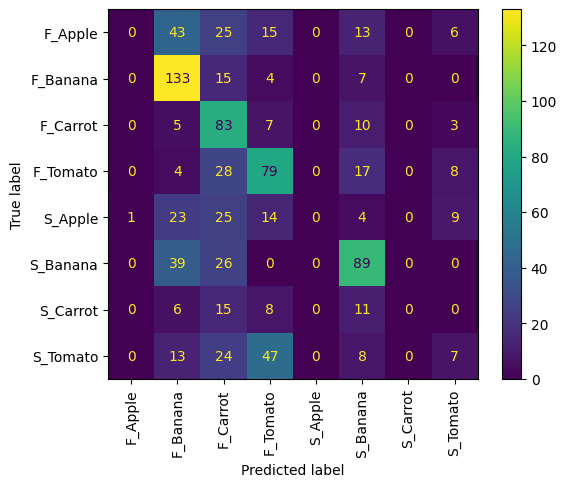

In [9]:
print("Evaluate")
#load test dataset
test_dataset = tf.keras.utils.image_dataset_from_directory(DATADIR_test,labels='inferred',batch_size=20,label_mode='categorical',image_size=(IMAGESIZE, IMAGESIZE))
#extract class names
classes = test_dataset.class_names



#rescale
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))
#test_dataset = train_ds[1]
#TODO: move to utils
#get predictions
predictions = np.array([])
labels =  np.array([])
for x, y in tqdm(test_dataset):
  # selecet the class for which i have the max confidence
  predictions = np.concatenate([predictions, np.argmax(model.predict(x,verbose=0), axis = -1)])
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

print(accuracy_score(labels, predictions))
t = confusion_matrix(labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=t,display_labels=classes)
disp.plot(xticks_rotation='vertical')
plt.show()


Save model and convert to TFlite

In [15]:
MODEL_NAME = "/home/mattiamorabito/Documents/HwAi-linux/savedmodels/QAT"
tf.saved_model.save(model, MODEL_NAME)

converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_NAME)
converter.optimizations = [tf.lite.Optimize.DEFAULT]


def representative_data_gen():                          # Uncomment the following 5 lines for Model 3
    for input_value, _ in test_dataset.take(20):
        yield [input_value]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
#converter.inference_input_type = tf.uint8
#converter.inference_output_type = tf.uint8

tflite_model = converter.convert()
tflite_models_dir = pathlib.Path("/home/mattiamorabito/Documents/HwAi-linux/tflite/")

tflite_model_file = tflite_models_dir/'QAT_noINT.tflite'
tflite_model_file.write_bytes(tflite_model)

2023-04-28 10:55:42.182956: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]
2023-04-28 10:55:42.196184: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,24]
	 [[{{node inputs}}]]
2023-04-28 10:55:42.497793: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]
2023-04-28 10:55:42

85376

Test quantized model

In [18]:
tflite_models_dir = pathlib.Path("/home/mattiamorabito/Documents/HwAi-linux/tflite/")
tflite_model_file = tflite_models_dir/'QAT_noINT.tflite'
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

predictions = []

test_ds = tf.keras.utils.image_dataset_from_directory(DATADIR_test,labels='inferred',batch_size=1,label_mode='categorical',image_size=(IMAGESIZE, IMAGESIZE))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

test_labels, test_imgs = [], []
for img, label in tqdm(test_ds):
    interpreter.set_tensor(input_index, img)
    interpreter.invoke()
    predictions.append(interpreter.get_tensor(output_index))
    test_labels.append(label.numpy()[0])
    test_imgs.append(img)


score = 0
for item in range(0,len(predictions)):
  prediction=np.argmax(predictions[item])
  label = np.argmax(test_labels[item])
  if prediction==label:
    score=score+1
print("| Out of 874 predictions I got " + str(score) + " correct | Accuracy: "+ str(score/len(predictions)*100) + "% |")

Found 874 files belonging to 8 classes.


  0%|          | 0/874 [00:00<?, ?it/s]2023-04-28 10:56:25.975124: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [874]
	 [[{{node Placeholder/_4}}]]
2023-04-28 10:56:25.976026: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [874]
	 [[{{node Placeholder/_4}}]]
100%|██████████| 874/874 [00:05<00:00, 160.39it/s]

| Out of 874 predictions I got 392 correct | Accuracy: 44.8512585812357% |


See model structure and history

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 58, 32)        25632     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 29, 29, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 32)        25632     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 32)       0

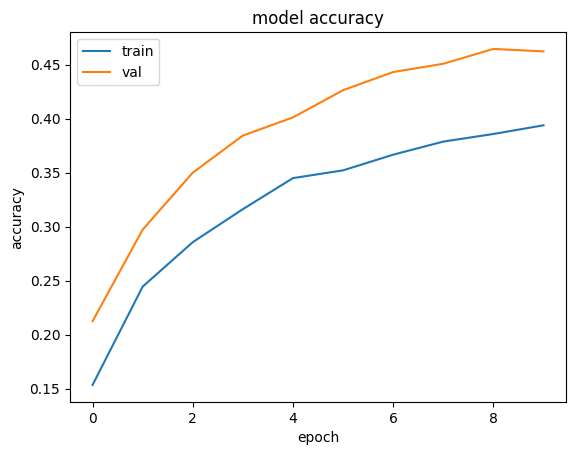

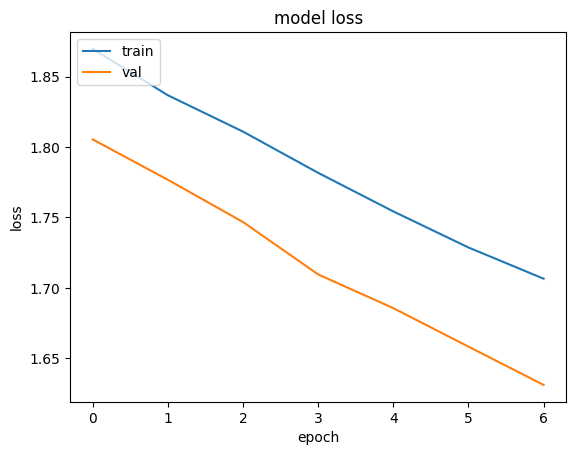

In [19]:
# see model structure
visualkeras.layered_view(model,legend=True).show() # display using your system viewer
model.summary()

# model training history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'][3:])
plt.plot(history.history['val_loss'][3:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Weight distrubution

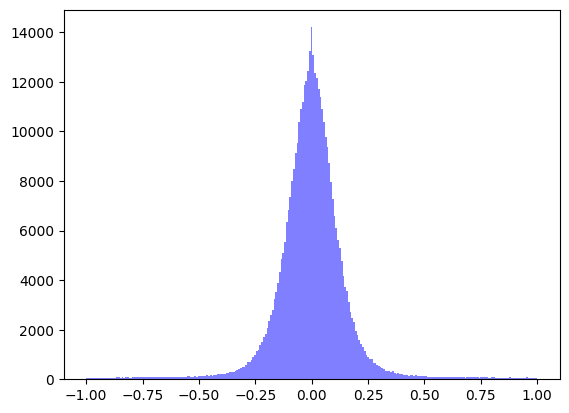

In [80]:
all_wi = []
wi = model.weights
for elem in wi:
  var = list(elem.read_value().numpy().flatten())
  all_wi= all_wi +var
s = np.array(all_wi)
sbins = np.linspace(-1,1,256)
plt.hist(s, bins=sbins, facecolor='blue', alpha=0.5)
plt.show()